In [1]:
%load_ext autoreload
%env PYTHONPATH=../

import sys
sys.path.append("../")

import os
print(os.environ["PYTHONPATH"])

import numpy as np
from tensorflow import keras
from oodeel.methods import MLS, DKNN, ODIN
from oodeel.methods import DKNN
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from oodeel.eval.metrics import bench_metrics, get_curve
from oodeel.datasets import OODDataset

from sklearn.metrics import *

import warnings
warnings.filterwarnings("ignore")

env: PYTHONPATH=../
../


2023-02-23 13:55:26.203577: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/paul/workspace/oodeel/oodeel_dev_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Two datasets experiment

In [35]:
%autoreload 2

oods_id = OODDataset('mnist', split="test")
oods_ood = OODDataset('fashion_mnist', is_ood=True, split="test")
oods_fit = OODDataset('mnist', split="train")
oods_test = oods_id.concatenate(oods_ood)

image_key = oods_test.input_key
labels = oods_test.ood_labels

def preprocess_fn(x, y):
    x = x / 255
    return x, y


batch_size = 128
ds_test = oods_test.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn, as_supervised=True, with_ood_labels=False)
ds_fit = oods_fit.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn, as_supervised=True, with_ood_labels=False, shuffle=True)

Loading from tensorflow_datasets
Loading from tensorflow_datasets
Loading from tensorflow_datasets


In [3]:

model = tf.keras.models.load_model("../saved_models/mnist_model")

Metal device set to: AMD Radeon Pro 5500M

systemMemory: 64.00 GB
maxCacheSize: 3.99 GB



2023-02-23 13:37:17.390103: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-23 13:37:17.391284: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-23 13:37:17.391344: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### MLS

In [51]:

%autoreload 2


oodmodel = MLS()
oodmodel.fit(model)
scores = oodmodel.score(ds_test)

fpr, tpr = get_curve(scores, labels)

metrics = bench_metrics(
    scores, labels, 
    metrics = ["auroc", "fpr95tpr", accuracy_score, roc_auc_score], 
    threshold = -5
    )

print(metrics)
plt.plot(fpr, tpr)
plt.show()


2023-02-22 21:34:09.185155: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-02-22 21:34:09.185258: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


ValueError: in user code:

    File "/Users/paul/workspace/oodeel/oodeel/models/keras_feature_extractor.py", line 121, in predict_tensor  *
        features = self.extractor(tensor)
    File "/Users/paul/workspace/oodeel/oodeel_dev_env/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/Users/paul/workspace/oodeel/oodeel_dev_env/lib/python3.9/site-packages/keras/engine/input_spec.py", line 197, in assert_input_compatibility
        raise ValueError(

    ValueError: Missing data for input "input_1". You passed a data dictionary with keys ['image', 'label']. Expected the following keys: ['input_1']


### DKNN

2023-02-22 21:30:01.046327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-22 21:30:04.974861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-22 21:30:22.114358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


{'auroc': 0.9986808250000001, 'fpr95tpr': 0.0044, 'accuracy_score': 0.5, 'roc_auc_score': 0.99868077}


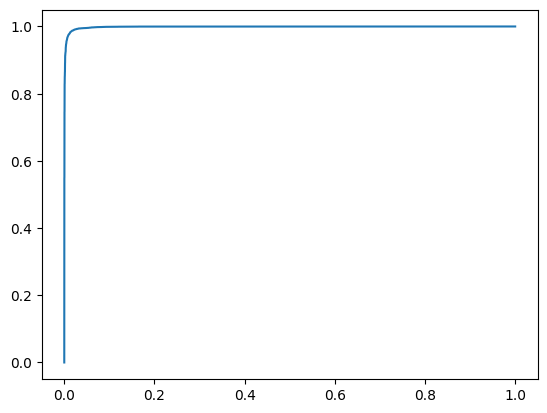

In [38]:
%autoreload 2


oodmodel = DKNN()
oodmodel.fit(model, ds_fit.take(10000))
scores = oodmodel.score(ds_test)

fpr, tpr = get_curve(scores, labels)
metrics = bench_metrics(
    scores, labels, 
    metrics = ["auroc", "fpr95tpr", accuracy_score, roc_auc_score], 
    threshold = -5
    )

print(metrics)
plt.plot(fpr, tpr)
plt.show()

### ODIN

2023-02-22 21:30:23.868294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-22 21:30:24.045779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-22 21:30:26.970275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-22 21:30:27.122631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


{'auroc': 0.9946918650000001, 'fpr95tpr': 0.0216, 'accuracy_score': 0.97115, 'roc_auc_score': 0.9946919099999999}


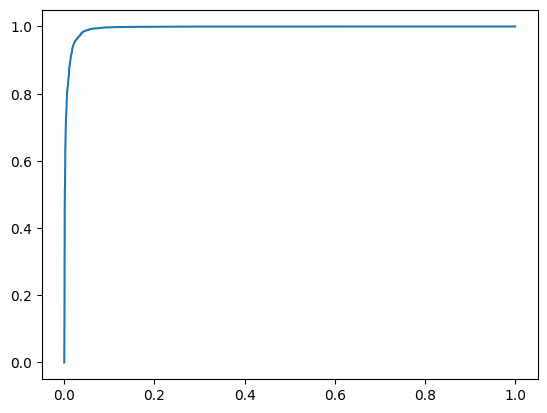

In [39]:

%autoreload 2
from oodeel.methods import ODIN

oodmodel = ODIN()
oodmodel.fit(model)
scores = oodmodel.score(ds_test)

fpr, tpr = get_curve(scores, labels)
metrics = bench_metrics(
    scores, labels, 
    metrics = ["auroc", "fpr95tpr", accuracy_score, roc_auc_score], 
    threshold = -5
    )

print(metrics)
plt.plot(fpr, tpr)
plt.show()

## Single dataset experiment

(Leave-$k$-classes-out training).
First, we need to define a training function

In [40]:

%autoreload 2

oods_test = OODDataset('mnist', split="test")
oods_train = OODDataset('mnist', split="train")

batch_size = 128
inc_labels = [0, 1, 2, 3, 4]
oods_id, _ = oods_train.assign_ood_labels_by_class(id_labels=inc_labels, return_filtered_ds=True)


Loading from tensorflow_datasets
Loading from tensorflow_datasets


2023-02-22 21:30:28.777396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-22 21:30:33.070127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-22 21:30:35.801777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-22 21:30:38.590404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [41]:

oods_test.assign_ood_labels_by_class(id_labels=inc_labels)

image_key = oods_test.input_key
labels = oods_test.ood_labels

def preprocess_fn(x, y):
    x = x / 255
    return x, y

ds_train = oods_id.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn, as_supervised=True, 
with_ood_labels=False, shuffle_buffer_size=10000)
ds_test = oods_test.prepare(batch_size=batch_size, as_supervised=True, with_ood_labels=False, preprocess_fn=preprocess_fn)
ds_fit = oods_id.prepare(batch_size=batch_size, as_supervised=True, with_ood_labels=False,preprocess_fn=preprocess_fn, shuffle=True)

2023-02-22 21:30:41.526741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-22 21:30:42.340029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [42]:
%autoreload 2
from oodeel.models.training_funs import train_convnet_classifier

train_config = {
    "input_shape": (28, 28, 1),
    "num_classes": len(inc_labels),
    "is_prepared": True,
    "batch_size": 128,
    "epochs": 5
}

model = train_convnet_classifier(ds_train, **train_config)

2023-02-22 21:30:43.091493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/5


2023-02-22 21:30:45.945370: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


240/240 [==============================] - 9s 33ms/step - loss: 0.2249 - accuracy: 0.9349
Epoch 2/5
240/240 [==============================] - 5s 22ms/step - loss: 0.0477 - accuracy: 0.9851
Epoch 3/5
240/240 [==============================] - 5s 22ms/step - loss: 0.0318 - accuracy: 0.9910
Epoch 4/5
240/240 [==============================] - 5s 22ms/step - loss: 0.0294 - accuracy: 0.9917
Epoch 5/5
240/240 [==============================] - 5s 22ms/step - loss: 0.0285 - accuracy: 0.9923


## MLS

2023-02-22 21:31:15.762398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-22 21:31:16.658152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


{'auroc': 0.9539496104169147, 'fpr95tpr': 0.19906596614127262, 'accuracy_score': 0.894, 'roc_auc_score': 0.9539504510666023}


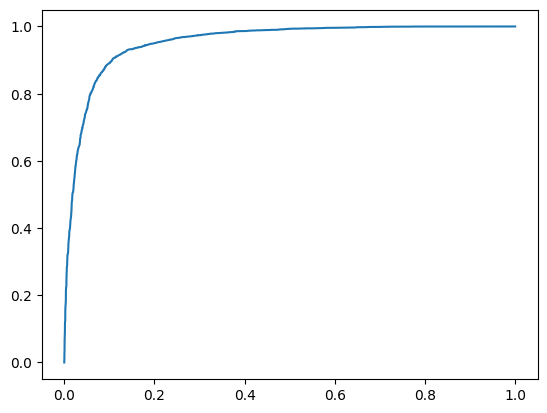

In [43]:
%autoreload 2

oodmodel = MLS()
oodmodel.fit(model)
scores = oodmodel.score(ds_test)

fpr, tpr = get_curve(scores, labels)
metrics = bench_metrics(
    scores, labels, 
    metrics = ["auroc", "fpr95tpr", accuracy_score, roc_auc_score], 
    threshold = -5
    )

print(metrics)
plt.plot(fpr, tpr)
plt.show()

### DKNN

2023-02-22 21:31:19.653885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-22 21:31:21.353226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-22 21:31:26.355646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


{'auroc': 0.9710087143748174, 'fpr95tpr': 0.1290134267367192, 'accuracy_score': 0.4861, 'roc_auc_score': 0.9710077936632546}


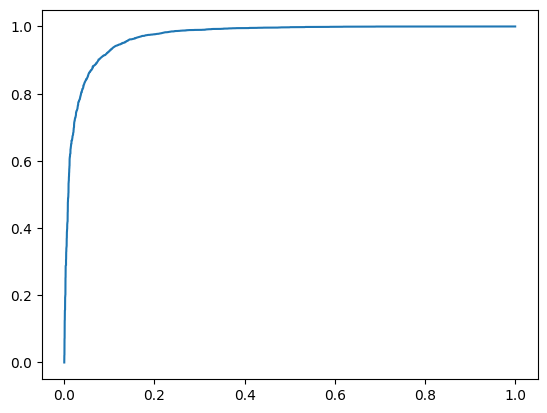

In [44]:
%autoreload 2

oodmodel = DKNN()
oodmodel.fit(model, ds_fit.take(10000))
scores = oodmodel.score(ds_test)

fpr, tpr = get_curve(scores, labels)
metrics = bench_metrics(
    scores, labels, 
    metrics = ["auroc", "fpr95tpr", accuracy_score, roc_auc_score], 
    threshold = -5
    )

print(metrics)
plt.plot(fpr, tpr)
plt.show()

### ODIN

2023-02-22 21:31:27.290001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-22 21:31:27.455774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-22 21:31:29.298012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-22 21:31:29.626636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


{'auroc': 0.9552095041131589, 'fpr95tpr': 0.19030939871570343, 'accuracy_score': 0.8774, 'roc_auc_score': 0.9552099044225338}


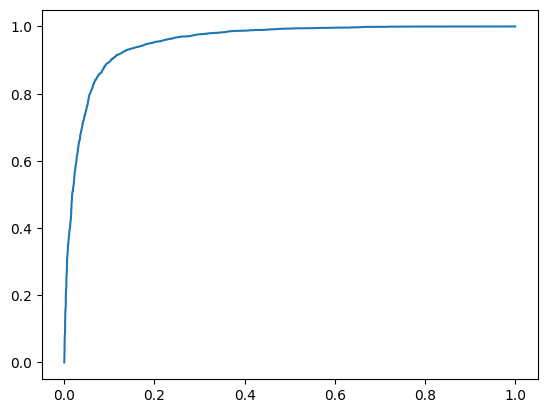

In [45]:
%autoreload 2

#x_test, y_id = data_handler.convert_to_numpy(x_id)

oodmodel = ODIN()
oodmodel.fit(model)
scores = oodmodel.score(ds_test)

fpr, tpr = get_curve(scores, labels)
metrics = bench_metrics(
    scores, labels, 
    metrics = ["auroc", "fpr95tpr", accuracy_score, roc_auc_score], 
    threshold = -5
    )

print(metrics)
plt.plot(fpr, tpr)
plt.show()